# **[PlantVillage Disease Classification Challenge](https://www.crowdai.org/challenges/plantvillage-disease-classification-challenge)**

PlantVillage is built on the premise that all knowledge that helps people grow food should be openly accessible to anyone on the planet.

**Overview**

We depend on edible plants just as we depend on oxygen. Without crops, there is no food, and without food, there is no life. It's no accident that human civilization began to thrive with the invention of agriculture.

Today, modern technology allows us to grow crops in quantities necessary for a steady food supply for billions of people. But diseases remain a major threat to this supply, and a large fraction of crops are lost each year to diseases. The situation is particularly dire for the 500 million smallholder farmers around the globe, whose livelihoods depend on their crops doing well. In Africa alone, 80% of the agricultural output comes from smallholder farmers.

With billions of smartphones around the globe, wouldn't it be great if the smartphone could be turned into a disease diagnostics tool, recognizing diseases from images it captures with its camera? This challenge is the first of many steps turning this vision into a reality. PlantVillage is a not-for-profit project by Penn State University in the US and EPFL in Switzerland. We have collected - and continue to collect - tens of thousands of images of diseased and healthy crops. ***The goal of this challenge is to develop algorithms than can accurately diagnose a disease based on an image.***

Here are the 38 classes of crop disease pairs that the dataset is offering.  To learn more about the background of the dataset, please refer to the following paper: https://arxiv.org/abs/1511.08060v2. You must cite this paper if you use the dataset. 



**Evaluation**

Submissions will be evaluated using a Multi Class Log Loss evaluation function.

In [1]:
import os
import pandas as pd
import numpy as np
import random
import cv2
import pathlib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from IPython.display import SVG
import IPython.display as display

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import warnings
warnings.filterwarnings("ignore")

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions


import keras.backend as K
from keras.models import Sequential

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

Using TensorFlow backend.


Next will be show few images samples from the data set:

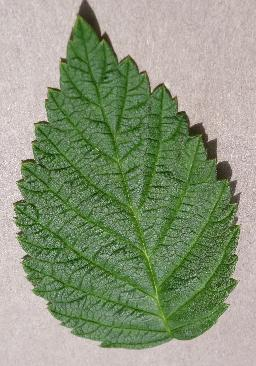

['c_23', '6043e3b8-9f0f-4ff1-a3ee-542c613633aa___Mary_HL 6335.JPG']


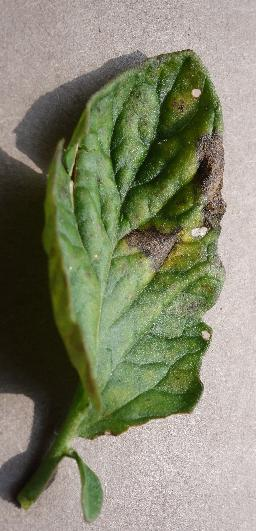

['c_30', '766771e1-8e8e-4ce4-9af6-b4ed91c9e80a___RS_Late.B 6881.JPG']


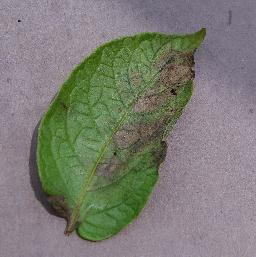

['c_21', 'd8ef0e69-3dfc-4d13-8d49-a44fa9cfa62e___RS_LB 4140.JPG']


In [2]:
rootDir = 'crowdai'
data_root = pathlib.Path(rootDir)
all_image_paths = list(data_root.glob('*/*'))
for i in range(0,3):
    image_example = str(random.choice(all_image_paths))
    display.display(display.Image(image_example))
    print(image_example.split("/")[-2:])
# The first value correspond to folder name and it is its label, next values is the file name

The first value correspond image folder name and it's its label, and next value is the file name

# Load data and create labels

- Create function to read the files in root, and get a list with labels and image names.

After several attempts, and try different aproach, I  choose this way, because the way of dataframe was created keep the same read system order, because the classes or labels are in the same order that jupyter is reading the data, and the code is more clean than other approachs I did tested. I like this consistency, even though the data reading is more slow, but I'm keeping this approach for this work.

In [3]:
def make_labels(rootDir):
    '''
    From a given root, this function return a pandas dataframe with the classes and file names
    The data read is slow but it garanties the order in pandas, as pc read the files.
    inpu:
        rootDir: Root dir which contains the files by classes folder names
    return:
        d: Is an empty dataframe, wich is populated by files names and ist respective classes.
    '''
    df = pd.DataFrame()   
    idx = 0 
    for lists in os.listdir(rootDir): 
        path = os.path.join(rootDir, lists)
        aux_list = []
        for path, dirs, files in os.walk(path):
            key = path.split("/")[-1:][0]
            for file in files:
                temp = pd.DataFrame({'label': key, 'img':file},index=[idx])
                idx +=1
                df = pd.concat([df, temp])
    return df


The next are the function test, in order to get classes and files names from folders.

In [4]:
df = make_labels(rootDir)
df.head()

,label,img
0,c_1,f2b57a5b-f46d-453a-bb33-21d01d8a10de___JR_FrgE...
1,c_1,73b7ad12-02d0-4775-8f51-c7d404177132___JR_FrgE...
2,c_1,50afe8c7-d56e-4dd0-97b8-23a70ddca819___JR_FrgE...
3,c_1,1ce4ecdf-fe69-42df-a0dc-c90f5495e7a1___JR_FrgE...
4,c_1,464511a6-77d9-493f-bb3c-f151fb390f1b___JR_FrgE...


In [5]:
# Read file function

def get_im_cv2(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (32, 32), cv2.INTER_LINEAR)
    return resized

In [6]:
# file read checking
path = '../crowdai/c_1/f2b57a5b-f46d-453a-bb33-21d01d8a10de___JR_FrgE.S 3036.JPG'
a = cv2.imread(path)
a

In [7]:
# Data vectors load function
# source: https://www.kaggle.com/satian/keras-mobilenet-starter

def load_img(df):
    '''
    '''    
    m = df.shape[0]
    X = np.zeros((m, 32, 32, 3))
    count = 0
    for i in range(0,m):
        img = image.load_img(rootDir+"/"+df.ix[i][0]+"/"+df.ix[i][1], target_size=(32, 32, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X[count] = x
        #if (count%1000 == 0):
        #    print("Processing image: ", count+1, ", ", fig)
        #count += 1
    label = list(df)[0]
    values = np.array(df[label])
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded    
    
    return X, y, label_encoder
    


In [8]:
# Data set construction
X, y, label_encoder = load_img(df)

# Data set normalization
X/=255

# Shape controls
print('X matrix shape', X.shape)
print('y vector shape', y.shape)

X matrix shape (21917, 32, 32, 3)
y vector shape (21917, 38)


In [9]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=123)

In [10]:
# Image Standarization

data_generator = image.ImageDataGenerator(rotation_range=90,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True)

data_generator.fit(X_train)

# standardize the test set
for i in range(len(X_test)):
    X_test[i] = data_generator.standardize(X_test[i])

## Neural Network Model

In [11]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

The first mode to train is a Resnet 50 with original data.

In [12]:
# Resnet50 model
model = ResNet50(input_shape=(32, 32, 3), include_top=True,weights= None, pooling='avg', classes=38)
model.compile(optimizer=Adam(lr=0.0005), loss='categorical_crossentropy',
              metrics=['acc'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
_____________________________________

In [13]:
# https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
# https://keras.io/models/sequential/
batch_size=64
epochs = 500

history = model.fit_generator(
    generator=data_generator.flow(x=X_train,
                                  y=y_train,
                                  batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    workers=4)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
273/273 [==============================] - 27s 99ms/step - loss: 3.3892 - acc: 0.1063 - val_loss: 3.3522 - val_acc: 0.1036
Epoch 2/500
273/273 [==============================] - 20s 74ms/step - loss: 3.3625 - acc: 0.1050 - val_loss: 3.3531 - val_acc: 0.0992
Epoch 3/500
273/273 [==============================] - 20s 72ms/step - loss: 3.3626 - acc: 0.1039 - val_loss: 3.3522 - val_acc: 0.1036
Epoch 4/500
273/273 [==============================] - 20s 73ms/step - loss: 3.3616 - acc: 0.1047 - val_loss: 3.3516 - val_acc: 0.1036
Epoch 5/500
273/273 [==============================] - 20s 73ms/step - loss: 3.3635 - acc: 0.1049 - val_loss: 3.3530 - val_acc: 0.1036
Epoch 6/500
273/273 [==============================] - 20s 73ms/step - loss: 3.3618 - acc: 0.1023 - val_loss: 3.3521 - val_acc: 0.1036
Epoch 7/500
273/273 [==============================] - 20s 73ms/step - loss: 3.3617 - acc: 0.1048 - val_loss: 3.3514 - val_acc: 0.1036
Epoch 8

273/273 [==============================] - 19s 70ms/step - loss: 3.3570 - acc: 0.1058 - val_loss: 3.3511 - val_acc: 0.1036 - lo
Epoch 119/500
273/273 [==============================] - 19s 70ms/step - loss: 3.3552 - acc: 0.1074 - val_loss: 3.3496 - val_acc: 0.1036
Epoch 120/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3581 - acc: 0.1079 - val_loss: 3.3502 - val_acc: 0.1036
Epoch 121/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3586 - acc: 0.1038 - val_loss: 3.3505 - val_acc: 0.1036
Epoch 122/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3537 - acc: 0.1066 - val_loss: 3.3498 - val_acc: 0.1036
Epoch 123/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3610 - acc: 0.1065 - val_loss: 3.3502 - val_acc: 0.1036
Epoch 124/500
273/273 [==============================] - 19s 70ms/step - loss: 3.3529 - acc: 0.1083 - val_loss: 3.3512 - val_acc: 0.1036
Epoch 125/500
273/273 [===========================

Epoch 178/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3552 - acc: 0.1088 - val_loss: 3.3502 - val_acc: 0.1036
Epoch 179/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3604 - acc: 0.1046 - val_loss: 3.3514 - val_acc: 0.1036
Epoch 180/500
273/273 [==============================] - 19s 70ms/step - loss: 3.3575 - acc: 0.1054 - val_loss: 3.3502 - val_acc: 0.1036
Epoch 181/500
273/273 [==============================] - 19s 70ms/step - loss: 3.3457 - acc: 0.1101 - val_loss: 3.3504 - val_acc: 0.1036
Epoch 182/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3659 - acc: 0.1041 - val_loss: 3.3492 - val_acc: 0.1036
Epoch 183/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3608 - acc: 0.1052 - val_loss: 3.3508 - val_acc: 0.1036
Epoch 184/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3505 - acc: 0.1090 - val_loss: 3.3492 - val_acc: 0.1036
Epoch 185/500
273/273 [==================

Epoch 297/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3547 - acc: 0.1090 - val_loss: 3.3495 - val_acc: 0.1036
Epoch 298/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3549 - acc: 0.1060 - val_loss: 3.3497 - val_acc: 0.1036
Epoch 299/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3583 - acc: 0.1053 - val_loss: 3.3501 - val_acc: 0.1036
Epoch 300/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3551 - acc: 0.1075 - val_loss: 3.3495 - val_acc: 0.1036
Epoch 301/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3561 - acc: 0.1064 - val_loss: 3.3505 - val_acc: 0.1036
Epoch 302/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3541 - acc: 0.1065 - val_loss: 3.3498 - val_acc: 0.1036
Epoch 303/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3580 - acc: 0.1065 - val_loss: 3.3501 - val_acc: 0.1036
Epoch 304/500
273/273 [==================

Epoch 357/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3599 - acc: 0.1061 - val_loss: 3.3495 - val_acc: 0.1036
Epoch 358/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3515 - acc: 0.1062 - val_loss: 3.3502 - val_acc: 0.1036
Epoch 359/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3574 - acc: 0.1083 - val_loss: 3.3496 - val_acc: 0.1036
Epoch 360/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3574 - acc: 0.1049 - val_loss: 3.3497 - val_acc: 0.1036
Epoch 361/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3504 - acc: 0.1084 - val_loss: 3.3499 - val_acc: 0.1036
Epoch 362/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3554 - acc: 0.1073 - val_loss: 3.3501 - val_acc: 0.1036
Epoch 363/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3549 - acc: 0.1048 - val_loss: 3.3499 - val_acc: 0.1036
Epoch 364/500
273/273 [==================

Epoch 476/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3573 - acc: 0.1073 - val_loss: 3.3498 - val_acc: 0.1036
Epoch 477/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3591 - acc: 0.1041 - val_loss: 3.3496 - val_acc: 0.1036
Epoch 478/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3554 - acc: 0.1076 - val_loss: 3.3501 - val_acc: 0.1036
Epoch 479/500
273/273 [==============================] - 19s 70ms/step - loss: 3.3547 - acc: 0.1063 - val_loss: 3.3498 - val_acc: 0.1036
Epoch 480/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3573 - acc: 0.1066 - val_loss: 3.3501 - val_acc: 0.1036
Epoch 481/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3563 - acc: 0.1063 - val_loss: 3.3496 - val_acc: 0.1036
Epoch 482/500
273/273 [==============================] - 19s 71ms/step - loss: 3.3543 - acc: 0.1062 - val_loss: 3.3497 - val_acc: 0.1036
Epoch 483/500
273/273 [==================

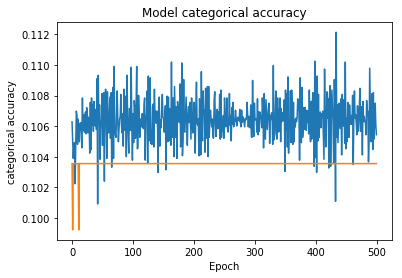

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model categorical accuracy')
plt.ylabel('categorical accuracy')
plt.xlabel('Epoch')
plt.show()